# BIKE SHARING DEMAND_ EDA & Ensemble Model (Top 10 Percentile)

* REF URL : https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

## Overview 

자전거 공유 시스템은 자전거 렌탈 수단의 일종으로서 멤버쉽가입, 렌탈, 자전거 반납 등의 프로세스가 도시 전체적으로 위치한 키오스크 네트워크를 통해 자동화 되어 있습니다. 이 시스템을 통해서 시민들은 자전거를 한 곳에서 빌려 원하는 다른 곳에 마음껏 반납할 수 있습니다. 현재, 세계적으로 500 곳이 넘는 자전거 공유 프로그램이 존재합니다. 

## Data Fields

* datetime : hourly date + timestamp
* season : 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday : whether the day is considered a holiday
* workingday : whether the day is neigher a weekened nor holiday
* wether :
    * 1 : Clear, Few clouds, Parly cloudy
    * 2 : Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3 : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4 : Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : temperature in Celsius
* atemp : "fells like" temperature in Celsius
* humidity : relative humidity
* windspeed : winddspeed
* casual : number of non-registered user rentals initiated
* registered : number of registered user rentals initiated
* count : number of total rentals (Dependent Variable)

In [33]:
import pylab
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline

In [34]:
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [35]:
test["weather"].unique()

array([1, 2, 3, 4])

### Lets Read In The Dataset

In [36]:
dailyData = pd.read_csv("train.csv")
dailyData.shape

(10886, 12)

### Sample of First Few Rows

In [37]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


### Variables Data Type

In [38]:
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Feature Engineering

앞서 데이터의 데이터타입을 보면 컬럼 "season", "holiday", "weather"의 경우 "범주형"데이터여야함을 알 수 있다. 그러나 현재 데이터 타입은 "정수(수치)형"이다. 따라서 아래와 같이 데이터 타입을 변경하고 EDA 를 시작해보자.

* Create new columns "date", "hour", "weekDay", "month" from "datetime" column.
* Coerce the datatype of "season", "holiday", "workingday" and weather to category.
* Drop the datetime column as we already extracted useful features from it.

### Creating New Columns From "Datetime" Column

In [39]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[
    datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[
    datetime.strptime(dateString, "%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1 : "Spring", 2 : "Summer", 3 : "Fall", 4 : "Winter"})
dailyData["weather"] = dailyData.weather.map({1 : "Clear + Few clouds + Parly cloudy + Partly cloudy", \
                                              2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ",\
                                              3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",\
                                              4 : " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog "})


In [40]:
dailyData.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January


### Coercing To Category Type

In [41]:
catergoryVariableList = ["hour", "weekday", "month","season","weather","holiday","workingday"]
for var in catergoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

### Dropping Unnacessary Columns

In [42]:
dailyData = dailyData.drop(["datetime"], axis = 1)

### Lets Start With Very Simple Visualisation Of Variables DataType Count

In [52]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(
    columns = {"index" : "variableType", 0 : "count" })
dataTypeDf["variableType"] = dataTypeDf["variableType"].astype(str)
dataTypeDf["variableType"].value_counts()

category    6
float64     1
object      1
int64       1
Name: variableType, dtype: int64

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'variableTypeariable Type'),
 Text(0.5, 1.0, 'Variables DataType Count')]

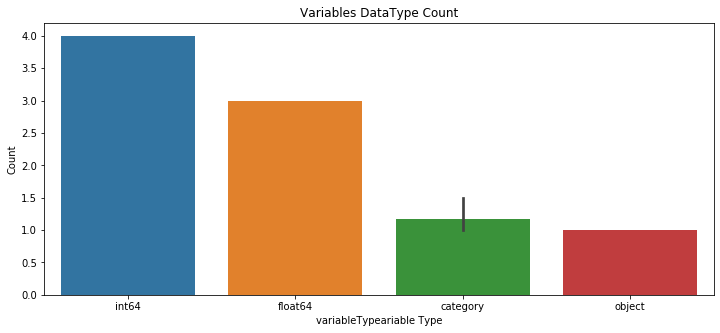

In [55]:
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sns.barplot(data = dataTypeDf, x ='variableType', y ='count', ax = ax)
ax.set(xlabel = 'variableTypeariable Type', ylabel = 'Count', title = 'Variables DataType Count')

## Missing Values Analysis

데이타와 컬럼을 전처리하고 나서 다음 단계는 일반적으로 결측값이 있는지 확이하는 것이다. 다행히도 이 데이터셋에서는 어떤 결측값도 발견되지 않았다. 보통 내가 선호하는 결측치 시각화 방법은 "missingno" 패키지를 이영하는 것이다. 

이 방법은 꽤 손쉽고, 빠르게 변수의 결측값을 시각화하는 방법이다. 앞서 이야기했든 우리는 이번 데이터셋에 결측치가 없으므로 운이 좋다고 할 수 있다. 

## Skewness In Distribution

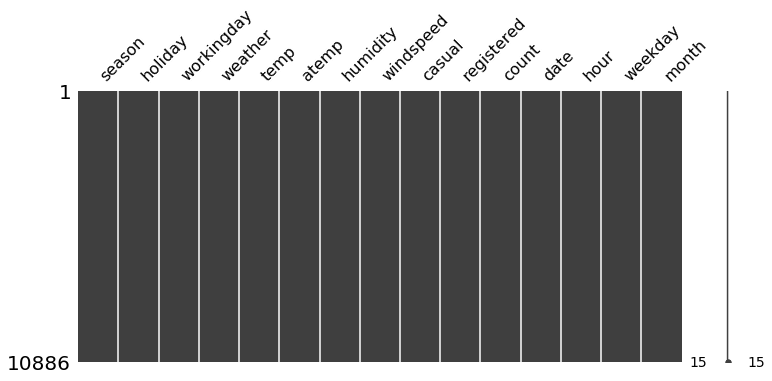

In [14]:
msno.matrix(dailyData, figsize = (12,5))

## Outliers Anaysis (이상치 분석)

처음 데이터를 살펴보았을 때, "count" 라는 변수에 이상치가 많이 존재하고, 해서 데이터가 오른쪽으로 쏠리는 현상이 있음을 발견했다. (사분위를 벗어나는 데이터가 더 많았기 때문이다.) 이에 더해, 단순한 박스플랏을 그려 하기와 같은 추론도 가능하다. 

* 봄 시즌은 비교적 낮은 count 값을 가진다. 박스플랏에서 중위값의 하락이 이를 뒷받침할 수 있다. 
* "Hour Of The Day"라는 박스플랏은 꽤 흥미롭다. "7AM - 8AM", "5PM - 6PM" 의 중위값은 비교적 높다. 이 시간 대는 학생과 회사원들의 이용시간으로 볼 수 있다.
* 대부분의 이상치는 주로 "Non Working Day" 가 아닌 "Working Day"에 발생하는데. 이는 figure 4에서 보다 두드러진다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

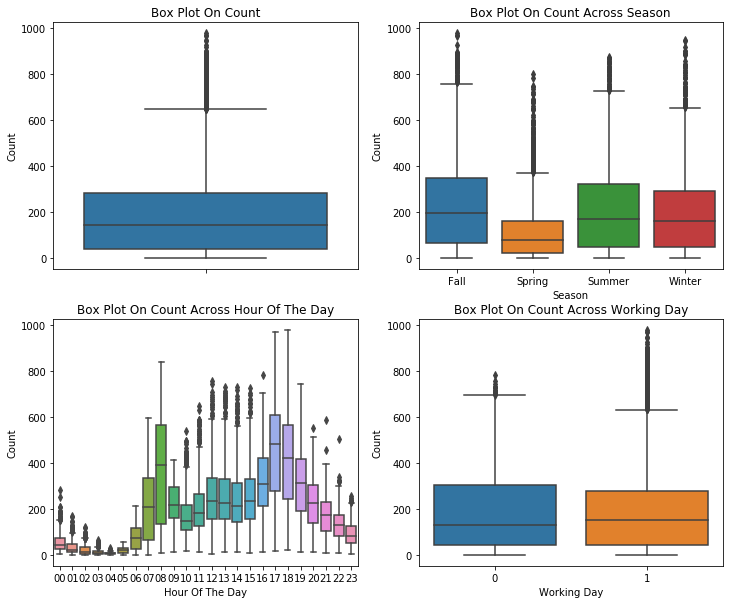

In [15]:
fig,axes = plt.subplots(nrows =2, ncols =2)
fig.set_size_inches(12,10)
sns.boxplot(data = dailyData, y = "count", orient = "v", ax = axes[0][0])
sns.boxplot(data = dailyData, y = "count", x = "season", orient = "v", ax = axes[0][1])
sns.boxplot(data = dailyData, y = "count", x = "hour", orient = "v", ax = axes[1][0])
sns.boxplot(data = dailyData, y = "count", x = "workingday", orient = "v", ax = axes[1][1])

axes[0][0].set(ylabel = "Count", title = "Box Plot On Count")
axes[0][1].set(xlabel = "Season", ylabel = "Count", title = "Box Plot On Count Across Season")
axes[1][0].set(xlabel = "Hour Of The Day", ylabel = "Count", title = "Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel = 'Working Day', ylabel = "Count", title = "Box Plot On Count Across Working Day")

### Lets Remove Outliers In The Count Column

In [16]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"] - dailyData["count"].mean()) <=(
3*dailyData["count"].std())]

In [17]:
print("Shape Of The Before Outliers : ", dailyData.shape)
print("Shape of The After Outliers : ", dailyDataWithoutOutliers.shape)

Shape Of The Before Outliers :  (10886, 15)
Shape of The After Outliers :  (10739, 15)


## Correlation Analysis (상관성 분석)

### Correlation Matrix 
종속변수가 다른 변수(수치형)에 영향을 받았는지 이해하기 위해서는 변수들을 correlation matrix 를 그려 이해하는 것이 보편적이다. 
목표변수 "count" 와 종속변수 ["temp", "atemp", "humidity", "windspeed"] 와 어떤 상관성이 있는지 플랏을 그려보자.

### Correlation Matrix 를 통한 변수 간 상관관계 분석 후 , 모델링 설계 
* "temp" 와 "humidity" 는 비교적으로 count 와 각각 양의 상관관계, 음의 상관관계를 가진다. 비록 둘 사이의 상관관계는 뚜렷하지 않지만, "count" 는 "temp" 와 "humidity"에 약간의 영향을 받는다.
* "windspeed" 는 그렇게 유용한 수치형 요소는 아니다. 이는 "count"와의 상관관계 계수에서 잘 드러난다
* "atemp" 라는 변수는 제외하였는데, 그 이유는 "atemp" 와 "temp" 가 서로 아주 높은 상관관계가 있기 때문이다. 다중 공산성 문제가 발생할 수 있기 때문에 모델링을 하면서 이들 중 하나는 삭제해야 한다.
* "casual" 과 "registered" 도 고려하지 않는다. 두 변수는 서로 간의 유출량이가 때문에 모델링 시, 제외되어야 한다.

### Regression Plot in Seaborn 
Seaborn 에서의 회기 플랏은 두 변수의 상관관계를 보여주는데 유용하다. 따라서 우리는 "count" vs "temp", "humidity", "windspeed" 로 회기플랏을 그려보자 

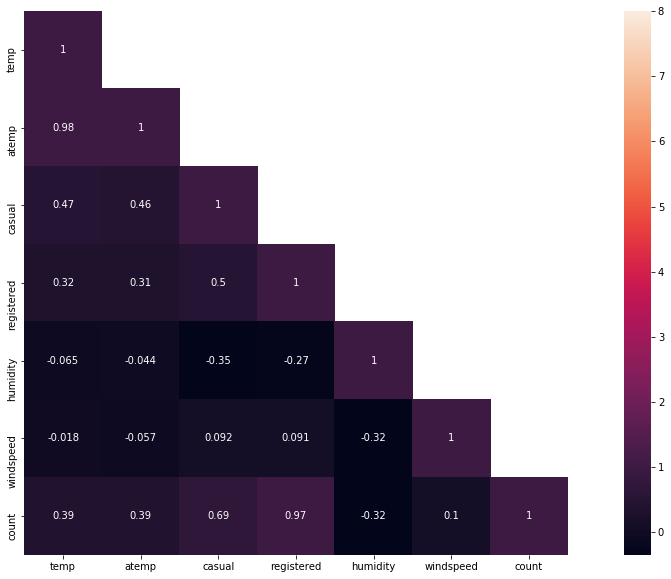

In [18]:
# 변수간의 상관계수를 데이터프레임으로 만듬
corrMatt = dailyData[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed','count']].corr()
# 위 데이터프레임을 행렬화 (리스트 안에 리스트 들어간 형태)
mask = np.array(corrMatt)
# 
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
# mask = mask : 히트맵의 반만 보이게 함, square = True : 정사각형으로 보이게함, annot = True : 상관계수 보이게함
sns.heatmap(corrMatt, mask = mask, vmax = 8, square = True, annot = True)

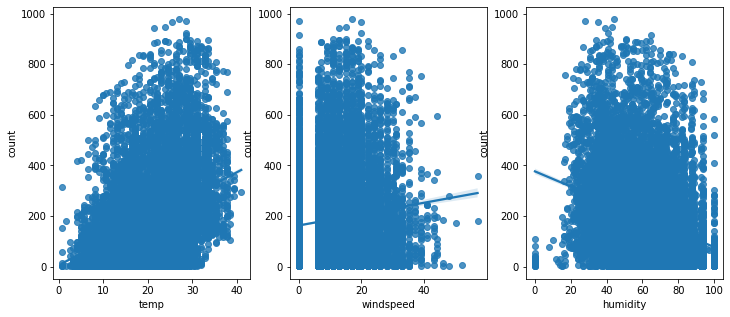

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x = "temp", y = "count", data = dailyData, ax = ax1)
sns.regplot(x = "windspeed", y = "count", data = dailyData, ax = ax2)
sns.regplot(x = "humidity", y = "count", data = dailyData, ax = ax3)

## Visualizing Distribution Of Data (데이터 분포 시각화)

하기 도표에서 보듯이 "count"변수는 오른쪽으로 치우쳐있습니다. 이는 정규분포화하기 이상적이라고 말할 수 있는데, 대부분의 머신러닝 테크닉엔 종속변수의 정규화가 필요하기 때문입니다. 한 가지 가능한 해결책으로는 이상치를 제거한 다음에 "count" 변수에 로그변환을 하는 것입니다. 변환을 하고 나면 데이터는 훨씬 보기 좋지만, 여전히 이상적인 정규분포를 따르지는 않습니다. 

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909615))

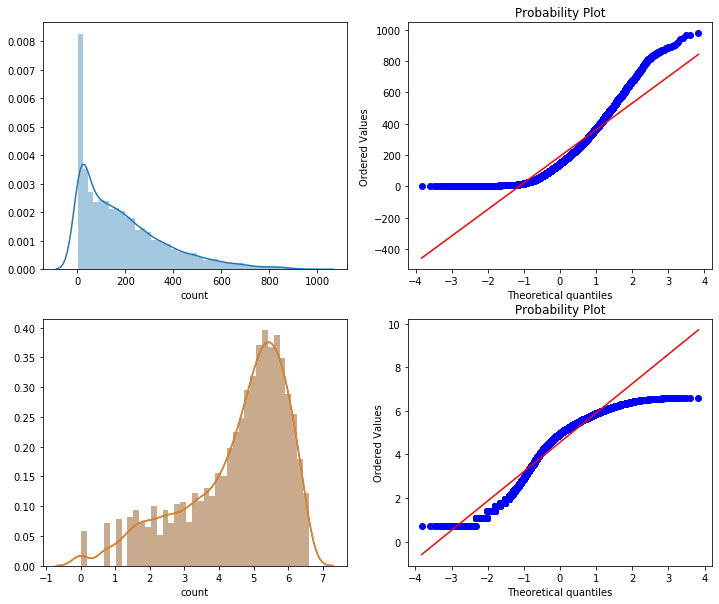

In [20]:
fig,axes = plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(12,10)
sns.distplot(dailyData["count"], ax = axes[0][0])
stats.probplot(dailyData["count"], dist = 'norm', fit = True, plot = axes[0][1])
sns.distplot(np.log(dailyDataWithoutOutliers["count"]), ax = axes[1][0])
sns.distplot(np.log(dailyDataWithoutOutliers["count"]), ax = axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist = "norm", fit = True, plot = axes[1][1])

## Visualizing Count vs (Month, Season, Hour, Weekday, Usertype) 시각화

* Month/Season : 결과를 보면 사람들은 여름에 자전거를 빌리는 경향이 뚜렸하다. 이 시기가 자전거 운용이 좋은 계절이기 때문이다. 그러므로 6/7/8월은 자전거 대여에 대해 비교적 높은 수요를 보인다.
* Hour/Weekday : 주중 7AM-8AM 그리고 5PM-6PM 에 자전거 대여는 더 높은데, 이는 통학/통근의 영향으로 보인다.
* 위의 패턴은 "토요일", "일요일"에는 보이지 않는다. 주말에는 10AM-4PM 에 대여하는 경향이 더 높다.
* 7AM-8AM 그리고 5PM-6PM 의 peak user(다이용자) 는 순수히 회원이다.

In [25]:
dailyData.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,Spring,0,0,Clear + Few clouds + Parly cloudy + Partly cloudy,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


[Text(0, 0.5, 'User Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

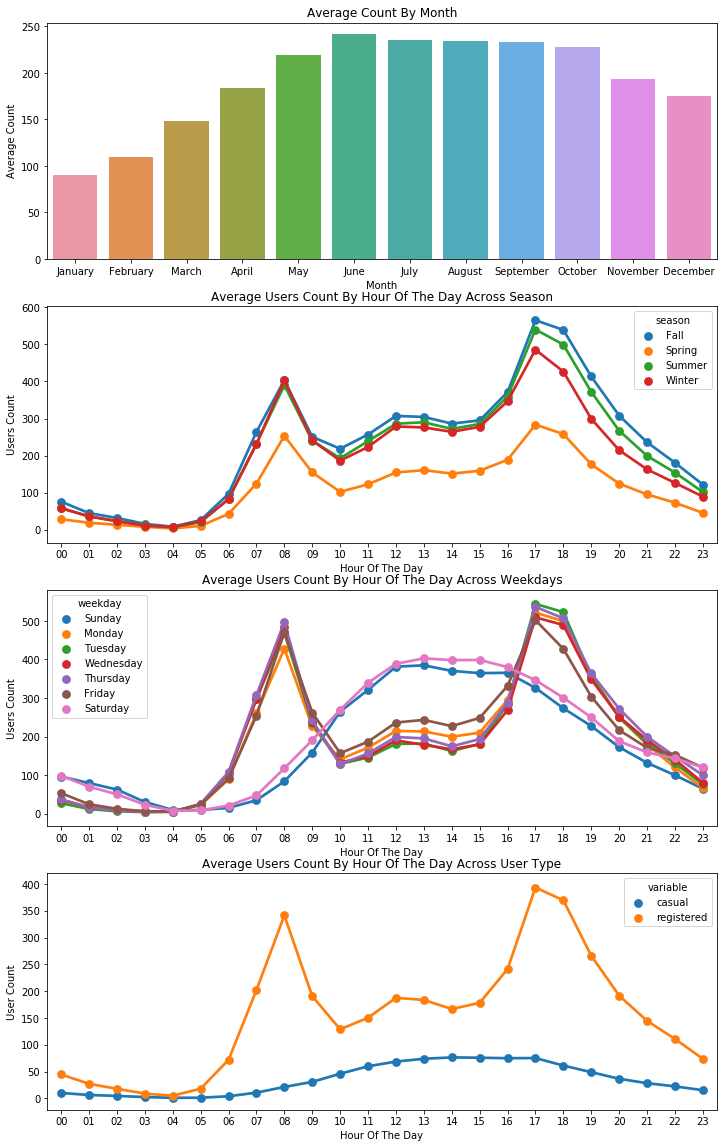

In [29]:
# 서브플랏 그리기 
fig,(ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(12,20)

# 중요변수 시각화 전 리스트로 담기 
sortOrder = ["January", "February", "March", "April", "May", "June", "July", "August", 
             "September", "October", "November", "December"]
hueOrder = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# 월 별 렌트 수 시각화 
monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by = 'count', ascending = False)
sns.barplot(data = monthSorted, x = 'month', y = 'count', ax = ax1, order = sortOrder)
ax1.set(xlabel = "Month", ylabel = "Average Count", title = "Average Count By Month")

# 시즌 별, 시간 별 렌트 수 시각화 
hourAggregated_1 = pd.DataFrame(dailyData.groupby(["hour", "season"], 
                                                sort = True)["count"].mean()).reset_index()
sns.pointplot(data = hourAggregated_1, x = hourAggregated_1['hour'], y = hourAggregated_1['count'],
             hue = hourAggregated_1["season"], join = True, ax = ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',
        title="Average Users Count By Hour Of The Day Across Season",label='big')

# 주중/주말 시간 별 렌트 수 시각화
hourAggregated_2 = pd.DataFrame(dailyData.groupby(["hour", "weekday"], 
                                                sort = True)["count"].mean()).reset_index()
sns.pointplot(data = hourAggregated_2, x = hourAggregated_2["hour"], y = hourAggregated_2["count"]
              , hue = hourAggregated_2["weekday"], hue_order = hueOrder, join = True, ax = ax3)
ax3.set(xlabel = "Hour Of The Day", ylabel = "Users Count", 
        title = "Average Users Count By Hour Of The Day Across Weekdays", label = 'big')

# 시간 별 이용자 등록 여부 tidy data 화하여 시각화 
hourTransformed = pd.melt(dailyData[["hour", "casual", "registered"]], 
                          id_vars = ['hour'], value_vars = ["casual", "registered"])
hourAggregated_3 = pd.DataFrame(hourTransformed.groupby(["hour", "variable"], 
                                                        sort = True)["value"].mean()).reset_index()
sns.pointplot(data = hourAggregated_3, x = hourAggregated_3["hour"], 
              y = hourAggregated_3["value"], hue = hourAggregated_3["variable"],
             hue_order = ["casual", "registered"], join = True, ax = ax4)
ax4.set(xlabel = "Hour Of The Day", ylabel = "User Count", 
        title = "Average Users Count By Hour Of The Day Across User Type", label = 'big')